# 3.2 Models

En esta iteración nos desharemos de los duplicados que surgen tras la eliminación del identificador único `EmployeeID`.

In [1]:
import pandas as pd

import sys
sys.path.append("..")
from src.support_models import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

Los hiperparámetros utilizados los mantendremos iguales.

In [3]:
parametros_logistic =  [{'penalty': ['l1'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['none'], 'solver': ['lbfgs'], 'max_iter': [10000]}]

parametros_dt = {'max_depth': [4, 10, 14, 25, 40],
            'min_samples_split': [6, 8, 10, 15, 20, 25],
            'min_samples_leaf': [6, 8, 10, 15, 20, 25],
            'max_leaf_nodes': [10, 15, 20, 25, 40, 60, 90, 110]}

parametros_rf = {
            'n_estimators' : [10,20,30,40],
            'max_depth': [5, 10, 15],
            'min_samples_split': [8, 10, 15, 20],
            'min_samples_leaf': [6, 8, 10, 15, 20],
            'max_leaf_nodes': [10, 15, 20, 25]
}

parametros_gb = {
    'n_estimators': [50,100],
    'max_depth': [3,5,7],
    'min_samples_split': [3,4,7],
    'min_samples_leaf': [3,4,7],
    'max_leaf_nodes': [6,10,12]
}

parametros_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
}

parametros_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]}

In [4]:
df = pd.read_pickle("../datos/prepped.pkl")

La diferencia clave es el dropeo de duplicados.

In [6]:
df_nodup = df.drop_duplicates()

In [7]:
df_nodup.to_pickle("../datos/prepped_nodup.pkl")

Separamos las VP de la VR.

In [ ]:
X = df_nodup.drop(columns=["Attrition"])
y = df_nodup["Attrition"]

E inicializamos el objeto que nos permitirá entrenar al modelo con diferentes métodos.

In [ ]:
model_nodup = ClassificationModel(X, y)

Aplicamos cada uno de los modelos.

In [ ]:
model_nodup.train(model_type="logistic", scoring="recall", params=parametros_logistic, verbose=1)
model_nodup.train(model_type="decision_tree", scoring="recall", params=parametros_dt, verbose=1)
model_nodup.train(model_type="gradient_boosting", scoring="recall", params=parametros_gb, verbose=1)
model_nodup.train(model_type="xgboost", scoring="recall", params=parametros_xgb, verbose=1)
model_nodup.train(model_type="random_forest", scoring="recall", params=parametros_rf, verbose=1)
model_nodup.train(model_type="svc", scoring="recall", params=parametros_svc, verbose=1)

Fitting 5 folds for each of 43 candidates, totalling 215 fits
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


SVC(C=10, kernel='poly', random_state=42)

Y obtenemos nuevamente la curva ROC.

El modelo 'svc' no soporta la función predict_proba y no se puede graficar la curva ROC.
El modelo 'svc' no soporta la función predict_proba y no se puede graficar la curva ROC.


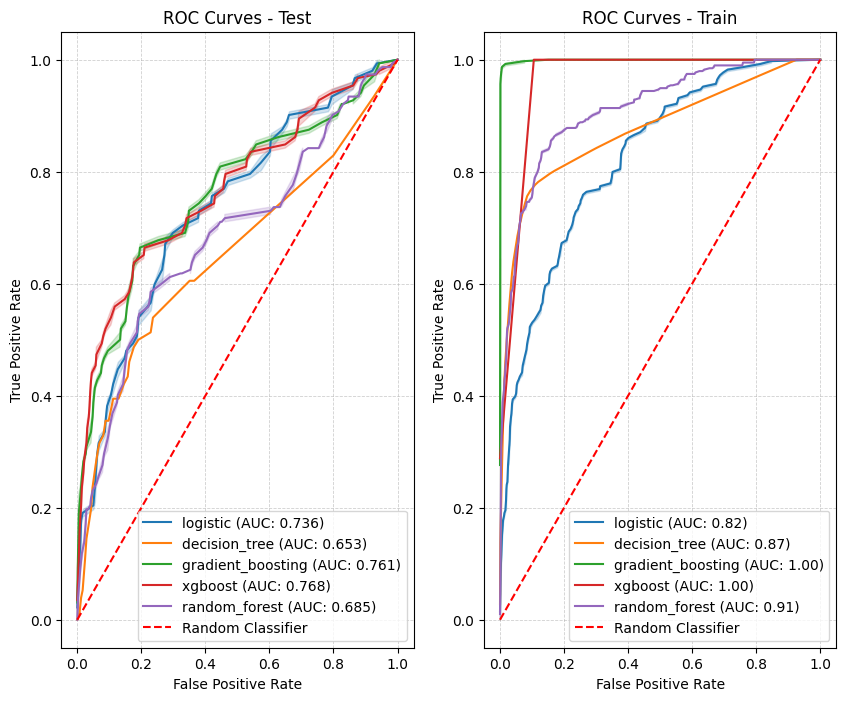

In [ ]:
model_nodup.plot_roc_curves()

En esta iteración, hemos eliminado los registros duplicados entre los conjuntos de entrenamiento y prueba. Como resultado, aunque los modelos siguen mostrando excelentes métricas en el conjunto de entrenamiento (ROC AUC cercano a 1 para `Gradient Boosting` y `XGBoost`), ahora tienen **dificultades para mantener el rendimiento en el conjunto de prueba**. Esto se debe a que los modelos ya no cuentan con registros compartidos entre ambos conjuntos, lo cual aumenta el desafío de generalizar a datos nuevos. Esta caída en el AUC, especialmente visible en el conjunto de prueba (valores entre 0.65 y 0.76), refleja la capacidad reducida de los modelos para generalizar y sugiere un ajuste excesivo a los datos de entrenamiento.


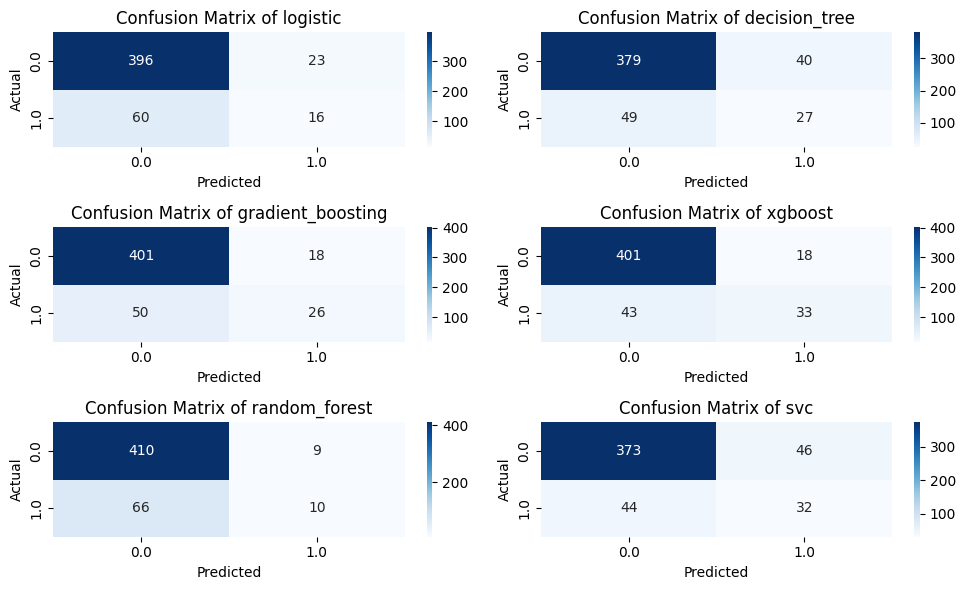

In [ ]:
model_nodup.plot_confusion_matrix()

En esta iteración, al eliminar duplicados entre los conjuntos de **train** y **test**, se observa un impacto significativo en el rendimiento de los modelos debido a la falta de similitud entre ambos conjuntos. Esto ha resultado en un aumento general de los **falsos negativos**, afectando negativamente el **recall**:

- **`XGBoost`**, **`Gradient Boosting`** y **`SVC`** mantienen el mejor **recall**, aunque han incrementado los falsos negativos (`XGBoost`: 43, `Gradient Boosting`: 50, `SVC`: 44). Sin los duplicados, el modelo tiene más dificultad para reconocer patrones en el conjunto de **test**.
- **`Decision Tree`** y **`Random Forest`** han mostrado una notable disminución en la capacidad de identificar positivos, con altos falsos negativos (`Decision Tree`: 49, `Random Forest`: 66).
- **`Logistic Regression`** muestra el menor rendimiento en recall, con solo 16 verdaderos positivos y 60 falsos negativos.

La eliminación de duplicados ha hecho que los datos de **test** sean menos similares a los de **train**, lo que incrementa los **falsos negativos** y reduce la capacidad de generalización de los modelos.


In [ ]:
df_metrics_nodup = pd.DataFrame()
for k in model_nodup.resultados.keys():
    df_it = model_nodup.resultados[k]["metrics"]
    df_it["method"] = k
    df_metrics_nodup = pd.concat([df_metrics_nodup, df_it])

df_resultados_colores_nodup = df_metrics_nodup.copy()
df_resultados_colores_nodup.reset_index(inplace = True)
df_resultados_colores_nodup = df_resultados_colores_nodup.style.apply(color_filas_por_modelo, axis=1)
df_resultados_colores_nodup

,index,precision,accuracy,recall,f1_score,kappa,auc,time,n_jobs,method
0,train,0.684783,0.858752,0.319797,0.435986,0.367210,0.824499,0.003005,None,logistic
1,test,0.410256,0.832323,0.210526,0.278261,0.194364,0.736277,0.003005,None,logistic
2,train,0.772152,0.903813,0.619289,0.687324,0.631297,0.874717,0.001996,12,decision_tree
3,test,0.402985,0.820202,0.355263,0.377622,0.273032,0.652525,0.001996,12,decision_tree
4,train,1.000000,0.980936,0.888325,0.940860,0.929544,0.999422,0.005998,12,gradient_boosting
5,test,0.590909,0.862626,0.342105,0.433333,0.361436,0.761085,0.005998,12,gradient_boosting
6,train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.021338,None,xgboost
7,test,0.647059,0.876768,0.434211,0.519685,0.452126,0.768025,0.021338,None,xgboost
8,train,0.962264,0.871750,0.258883,0.408000,0.361807,0.911759,0.046405,-1,random_forest
9,test,0.526316,0.848485,0.131579,0.210526,0.158869,0.685278,0.046405,-1,random_forest


- **Disminución del Recall**: En todos los modelos, el **recall** en el conjunto de **test** ha disminuido considerablemente comparado con la iteración anterior. Esto se debe a que sin duplicados, el conjunto de **test** ya no es similar al de **train**, lo cual hace que los modelos tengan más dificultad para identificar correctamente la clase positiva. Por ejemplo, **`XGBoost`** pasa de un recall perfecto (1.0) en **train** a solo 0.434 en **test**.
  
- **Evidencia de Overfitting**: Modelos como **`XGBoost`** y **`Gradient Boosting`** siguen mostrando métricas perfectas o muy altas en el conjunto de **train** (recall de 1.0 y 0.888, respectivamente), pero una caída considerable en **test**. Esto indica que los modelos están sobreajustando los datos de **train** y no generalizan bien en el conjunto de **test** sin duplicados.

- **`Logistic Regression` y `Random Forest`** también han mostrado una caída notable en el **recall** en **test** (`Logistic Regression`: de 0.319 a 0.211; `Random Forest`: de 0.259 a 0.132), lo cual evidencia que la falta de duplicados ha hecho que sea más difícil para estos modelos captar la variabilidad presente en los datos.

En general, la eliminación de duplicados ha aumentado la complejidad de la generalización, lo que se refleja en un rendimiento significativamente menor en **recall** en el conjunto de **test** para todos los modelos. Esto sugiere la importancia de tener datos de **train** y **test** con suficiente similitud para mejorar la capacidad predictiva de los modelos.
